In [8]:
import csv
import fileinput
import pickle
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

In [9]:
def timestamp(seconds):
    minutes, seconds = divmod(seconds, 60)
    hours, minutes = divmod(minutes, 60)
    hours = int(hours)
    minutes = int(minutes)
    if hours:
        return f'{hours}:{minutes}:{seconds:0.3f}'
    elif minutes:
        return f'{minutes}:{seconds:0.3f}'
    else:
        return f'{seconds:0.3f}'

In [10]:
def load_data_dir(path):
    data = None
    for filename in os.listdir(path):
        new = np.genfromtxt(os.path.join(path, filename), delimiter=',')
        if data is None:
            data = new
        else:
            data = np.concatenate((data, new))
    return np.split(data, (-1,), axis=1)

test_data, test_labels = load_data_dir('../brain-data/test')
validation_data, validation_labels = load_data_dir('../brain-data/validation')
train_data, train_labels = load_data_dir('../brain-data/train')

In [11]:
def create_model(path, train_data, train_labels, *, criterion='gini', overwrite=False, n_estimators=50,
                 max_depth=15, random_state=123456):
    if os.path.isfile(path) and not overwrite:
        print('loading model...')
        with open(path, 'rb') as f:
            rf = pickle.load(f)
        print(f'Model loaded! Original training time {timestamp(rf.training_time)}')
    else:
        resp = input('type "train" to confirm you want to train a new model: ')
        if resp != 'train':
            print('training aborted')
            return
        else:
            now = time.time()
            print(f'training... {time.strftime("%H:%M:%S", time.localtime())}')
            rf = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion,
                                        max_depth=max_depth, random_state=random_state)
            rf.fit(train_data, train_labels.ravel().astype(int))
            rf.training_time = time.time() - now
            print(f'trained! Elapsed time {timestamp(rf.training_time)}')
            with open(path, 'wb') as f:
                pickle.dump(rf, f)
    return rf

In [38]:
gini = create_model('../models/random_forest_classifier_gini.pickle', test_data, test_labels)
entropy = create_model('../models/random_forest_classifier_entropy.pickle', test_data, test_labels)

loading model...
Model loaded! Original training time 17:58.696
loading model...
Model loaded! Original training time 11:12.525


In [45]:
def measure_accuracy(model, test_data, test_labels):
    predicted = model.predict(test_data)
    accuracy = accuracy_score(test_labels, predicted)
    print(f'Mean validation accuracy: {accuracy*100:.3f}%')
    
    target_names = ['background', 'foreground']
    cm = pd.DataFrame(confusion_matrix(test_labels, predicted), columns=target_names,
                      index=target_names)
    cm = cm.apply(np.log10)
    cm = cm / cm.values.sum()
    ax = sns.heatmap(cm, annot=True)
    ax.set_title('Log-Normalized Validation Accuracy')

In [57]:
def save_prediction(model, path, validation_data):
        predicted = model.predict(validation_data)
        pd.DataFrame(predicted).to_csv(path, header=False, index=False)

Mean validation accuracy: 99.767%


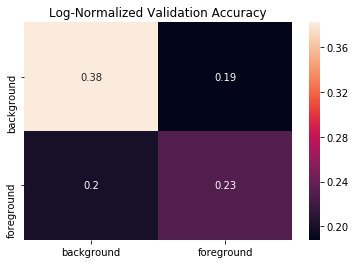

In [59]:
measure_accuracy(gini, test_data, test_labels)
save_prediction(gini, '../output/gini_predictions.csv', validation_data)

Mean validation accuracy: 99.768%


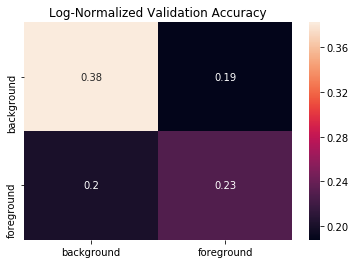

In [61]:
measure_accuracy(entropy, test_data, test_labels)
save_prediction(gini, '../output/entropy_predictions.csv', validation_data)

In [13]:
def partition_data(n, path):
    files = [os.path.join(path, p) for p in os.listdir(path)
             if os.path.isfile(os.path.join(path, p))]
    #total size of dataset
    size = 0
    for filename in files:
        size += os.path.getsize(filename)
        
    output_files = []
    dirpath = os.path.join(path, 'partitioned')
    with fileinput.input(files=files) as f:
        for i in range(n):
            data = ''
            
            if i < n - 1:
                while len(data) < size / n:
                    data += f.readline() + '\n'
            else:
                for line in f:
                    data += line + '\n'
            
            outfile = os.path.join(path, f'part_{i}.pickle')
            output_files.append(outfile)
            ndarr = pd.read_csv(data).values
            data, labels = np.split(ndarr, (-1,), axis=1)
        
            with open(outfile, 'wb') as fo:
                pickle.dump((data, labels), fo)
        
    return output_files
    
    
def train_large_forest(n_estimators, modelpath, datapath, *, criterion='gini', overwrite=False,
                 max_depth=15, random_state=123456):
    files = partition_data(n_estimators, datapath)
    trees = []
    for i, filename in enumerate(files):
        with open(filename, 'rb') as f:
            train_data, test_data = pickle.load(f)
        dt = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth,
                                    random_state=random_state)
        dt.fit(train_data, train_labels)
        with open(os.path.join(modelpath, f'decision_tree_{criterion}_{i}.pickle')) as f:
            pickle.dump(dt, f)
        trees.append(dt)
    
    return rf

    
def create_large_model(path, datapath, *, criterion='gini', overwrite=False, n_estimators=50,
                 max_depth=15, random_state=123456):
    if os.path.isfile(path) and not overwrite:
        print('loading model...')
        with open(path, 'rb') as f:
            rf = pickle.load(f)
        print(f'Model loaded! Original training time {timestamp(rf.training_time)}')
    else:
        resp = input('type "train" to confirm you want to train a new model: ')
        if resp != 'train':
            print('training aborted')
            return
        else:
            now = time.time()
            print(f'training... {time.strftime("%H:%M:%S", time.localtime())}')
            
            rf = train_large_forest(n_estimators, path, datapath, criterion=criterion,
                    max_depth=max_depth, random_state=random_state)
            rf.training_time = time.time() - now
            
            print(f'trained! Elapsed time {timestamp(rf.training_time)}')
            with open(path, 'wb') as f:
                pickle.dump(rf, f)
    return rf

In [ ]:
entropy_full = create_large_model('../models/random_forest_classifier_full_entropy.pickle',
                                  '../brain-data/full-train')
measure_accuracy(entropy_full, test_data, test_labels)

type "train" to confirm you want to train a new model: train
training... 23:18:14
